In [ ]:
!pip install simpy

In [ ]:
import gc
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from statsmodels.stats.multitest import multipletests
from transformers import GPT2LMHeadModel, GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
gen_model_names = ['gpt2', 'gpt2-medium']
judge_model_name = 'gpt2-large'

print("Loading generation models...")
gen_models = {}
tokenizers = {}
for mname in gen_model_names:
    print(f"Loading {mname} for generation...")
    tokenizer = GPT2Tokenizer.from_pretrained(mname)
    tokenizer.padding_side = "left"
    tokenizer.pad_token = tokenizer.eos_token
    tokenizers[mname] = tokenizer

    model = GPT2LMHeadModel.from_pretrained(mname)
    model.to(device)
    model.eval()
    gen_models[mname] = model

print("\nLoading judge model (gpt2-large) for logic scoring...")
tokenizer_judge = GPT2Tokenizer.from_pretrained(judge_model_name)
tokenizer_judge.padding_side = "left"
tokenizer_judge.pad_token = tokenizer_judge.eos_token
model_judge = GPT2LMHeadModel.from_pretrained(judge_model_name)
model_judge.to(device)
model_judge.eval()

print("\nAll models loaded.\n")

Loading generation models...
Loading gpt2 for generation...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading gpt2-medium for generation...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Loading judge model (gpt2-large) for logic scoring...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


All models loaded.



In [ ]:
base_queries = [
    "How are you?",
    "What is the meaning of life?",
    "Explain quantum entanglement.",
    "How to cook borscht?",
    "Who was Albert Einstein?",
    "What's the weather like?",
    "Tell me a joke about space.",
    "What do you think about AI?",
    "Why is the sky blue?",
    "What is the capital of France?",
    "What's the best way to stay healthy?",
    "Describe a cat flying in space with a rainbow.",
    "How to learn Python quickly?",
    "What's the difference between a list and a tuple in Python?",
    "What's your opinion on quantum computing?"
]


queries = [random.choice(base_queries) for _ in range(100)]

In [ ]:
def calculate_perplexity(model, tokenizer, text):
    # Tokenize text and move to device
    inputs = tokenizer.encode(text, return_tensors='pt').to(device)

    # Disable gradient calculation
    with torch.no_grad():
        # Get model loss
        loss = model(inputs, labels=inputs).loss

    # Return perplexity
    return float(torch.exp(loss))


In [ ]:
def generate_text(model, tokenizer, prompt,
                  use_cache=True,
                  max_gen_length=90,
                  temperature=0.9,
                  top_k=30,
                  top_p=0.85):
    # Tokenize prompt and move to device
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)

    # Disable gradient calculation
    with torch.no_grad():
        # Generate text using the model
        output_ids = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=inputs['input_ids'].shape[1] + max_gen_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
            use_cache=use_cache
        )

    # Decode generated text and remove special tokens
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return generated_text


In [ ]:
def measure_inference(model, tokenizer,
                      query_list,
                      batch_size,
                      use_cache,
                      input_length,
                      judge_model,
                      judge_tokenizer,
                      temperature=0.9,
                      top_k=30,
                      top_p=0.85):
    # Initialize lists for metrics and answers
    all_times = []
    all_mem = []
    answers_data = []

    # Split queries into batches
    batches = [query_list[i:i + batch_size] for i in range(0, len(query_list), batch_size)]

    for batch in tqdm(batches, desc="Processing batches", leave=False):
        # Reset memory stats and synchronize GPU
        torch.cuda.reset_peak_memory_stats(device)
        torch.cuda.synchronize(device)
        start_time = time.time()

        # Generate answers for the batch
        for q in batch:
            _ = generate_text(model, tokenizer, q,
                              use_cache=use_cache,
                              max_gen_length=90,
                              temperature=temperature,
                              top_k=top_k,
                              top_p=top_p)

        # Measure time and memory usage
        torch.cuda.synchronize(device)
        end_time = time.time()
        inference_time = (end_time - start_time)
        peak_mem = torch.cuda.max_memory_allocated(device) / (1024**2)

        all_times.append(inference_time)
        all_mem.append(peak_mem)

        # Evaluate perplexity for generated answers
        for q in batch:
            answer = generate_text(model, tokenizer, q,
                                   use_cache=use_cache,
                                   max_gen_length=90,
                                   temperature=temperature,
                                   top_k=top_k,
                                   top_p=top_p)
            ppl = calculate_perplexity(judge_model, judge_tokenizer, answer)
            answers_data.append((q, answer, ppl))

    # Compute average time and memory usage
    avg_time = np.mean(all_times)
    avg_mem = np.mean(all_mem)

    return avg_time, avg_mem, answers_data


In [ ]:
factors = {
    'model_name': list(gen_models.keys()),
    'use_cache': [True, False],
    'batch_size': [4, 8, 16],
    'input_length': [20, 50],
    'temperature': [0.7, 0.9],
    'top_k': [30],
    'top_p': [0.85]
}


experiment_design = list(product(*factors.values()))
print(f"Number of experiments: {len(experiment_design)}")

Number of experiments: 48


In [ ]:
results_list = []
all_experiment_answers = []

# Iterate through experiment designs
for idx, (model_name, use_cache, batch_size, input_length, temperature, top_k, top_p) in enumerate(tqdm(experiment_design, desc="DoE Experiments")):
    # Print experiment details
    print(f"\nExperiment {idx+1}/{len(experiment_design)}:")
    print(f"   model={model_name}, use_cache={use_cache}, batch_size={batch_size}, input_length={input_length}, temperature={temperature}, top_k={top_k}, top_p={top_p}")

    # Load model and tokenizer
    model = gen_models[model_name]
    tokenizer = tokenizers[model_name]

    # Measure inference performance and collect answers
    inference_time, memory_usage, answers_data = measure_inference(
        model=model,
        tokenizer=tokenizer,
        query_list=queries,
        batch_size=batch_size,
        use_cache=use_cache,
        input_length=input_length,
        judge_model=model_judge,
        judge_tokenizer=tokenizer_judge,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p
    )

    # Calculate average logic score (perplexity)
    logic_scores = [item[2] for item in answers_data]
    avg_logic = np.mean(logic_scores)

    # Print results for the current experiment
    print(f"   => Results: Inference Time ~ {inference_time:.3f} sec, Memory ~ {memory_usage:.1f} MB, Perplexity ~ {avg_logic:.4f}")

    # Store results in a dictionary
    results_list.append({
        'model_name': model_name,
        'use_cache': use_cache,
        'batch_size': batch_size,
        'input_length': input_length,
        'temperature': temperature,
        'top_k': top_k,
        'top_p': top_p,
        'inference_time': inference_time,
        'memory_usage': memory_usage,
        'perplexity': avg_logic
    })

    # Display a random generated answer
    random_answer_data = random.choice(answers_data)
    rand_q, rand_a, rand_ppl = random_answer_data
    print(f"   => Random answer: perplexity {rand_ppl:.4f}")
    print(f"      Q: {rand_q}\n      A: {rand_a}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results_list)
print("\n=== Final DoE Results DataFrame ===")
print(results_df)


DoE Experiments:   0%|          | 0/48 [00:00<?, ?it/s]


Experiment 1/48:
   model=gpt2, use_cache=True, batch_size=4, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.440 sec, Memory ~ 4954.2 MB, Perplexity ~ 23.5845
   => Random answer: perplexity 16.9414
      Q: What is the meaning of life?
      A: What is the meaning of life? Is it a good or bad thing to live in an unhappy world?"
"It's not just about money. It isn't even really what we need."
This answer has been asked many times before and I have found myself agreeing with this one time too often, but for some reason when you say "life", then people think that there are no more lives than those which were created by God; these things can only be said as if they

Experiment 2/48:
   model=gpt2, use_cache=True, batch_size=4, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.158 sec, Memory ~ 4954.1 MB, Perplexity ~ 28.6815
   => Random answer: perplexity 31.9080
      Q: What's the weather like?
      A: What's the weather like?
It depends. I mean, how much snow are you supposed to cover in a day?" "I'd guess that it might be around 8pm or 9:30am and they'll say something about rain." There is no such thing as good sunshine when people live on less than 24 hours notice of danger from windstorms which has been linked with increased incidence rates of heart attacks among teenagers over 25 years old (the National Health Service reported 742

Experiment 3/48:
   model=gpt2, use_cache=True, batch_size=4, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.397 sec, Memory ~ 4954.1 MB, Perplexity ~ 25.2845
   => Random answer: perplexity 35.8677
      Q: Why is the sky blue?
      A: Why is the sky blue?
The moon's coloration varies according to your latitude, but it can also be due both to its bright colors and a higher amount of light. The sun tends toward reds while in cooler climates such as Australia or New Zealand (the latter being more reflective). It appears that there are no obvious differences between "blue" stars with their darker colored regions from this perspective: they all have brighter areas around them like an apple tree on top of a

Experiment 4/48:
   model=gpt2, use_cache=True, batch_size=4, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.472 sec, Memory ~ 4954.1 MB, Perplexity ~ 28.4570
   => Random answer: perplexity 30.0175
      Q: Who was Albert Einstein?
      A: Who was Albert Einstein?
We don't know. But there is no doubt that his name has become a symbol of the modern world, and it's not just in Russia where he died; even though most scientists think only about him as one person from which to draw conclusions on all these issues (in fact they have been saying for many years), but also across Europe too: we may never see this man again because what happened here might happen anywhere else or more likely than

Experiment 5/48:
   model=gpt2, use_cache=True, batch_size=8, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.338 sec, Memory ~ 4954.3 MB, Perplexity ~ 22.5970
   => Random answer: perplexity 20.0098
      Q: What is the meaning of life?
      A: What is the meaning of life?
It's not a question that I'm asking. It was about my relationship with God, and how we were meant to live it as Christians in our own way. That wasn't something anyone should be asked or expected by anybody else on this earth! The Bible says no one has an answer for you unless they're told otherwise (see 2 Timothy 4:3-4). What does "life" mean when people say anything negative towards your character

Experiment 6/48:
   model=gpt2, use_cache=True, batch_size=8, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.680 sec, Memory ~ 4954.3 MB, Perplexity ~ 28.6434
   => Random answer: perplexity 30.3301
      Q: What's your opinion on quantum computing?
      A: What's your opinion on quantum computing? What are some of the implications for technology and society, as well a future that we can all embrace?"
. . The Future Is Possible : In his essay "The End Of Quantum Computing," Michael O'Reilly explains how there is much to learn about what will happen when humans start making computers out-of--the same way you might think it would be interesting if our world had no electricity or water; in other words: whether human intelligence could

Experiment 7/48:
   model=gpt2, use_cache=True, batch_size=8, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.498 sec, Memory ~ 4954.3 MB, Perplexity ~ 23.2813
   => Random answer: perplexity 29.6827
      Q: What's your opinion on quantum computing?
      A: What's your opinion on quantum computing?
I don't know if you can say it because I haven`t seen any papers that have shown this yet. But for those of us who are interested, the idea is there to make an artificial intelligence better at something we like and want instead; not a machine in control but simply one able enough with its brain to understand what people do or write about them."

Experiment 8/48:
   model=gpt2, use_cache=True, batch_size=8, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.415 sec, Memory ~ 4954.2 MB, Perplexity ~ 28.9594
   => Random answer: perplexity 18.3661
      Q: Why is the sky blue?
      A: Why is the sky blue?
The answer to this question depends on whether you are a man or an angel. The difference between men and angels has nothing to do with skin color, but what we have learned about it from other religions does reflect our belief in eternal life as God's Word of Life (see 2 Corinthians 10:15-17). It was said that "if there were any living creature who could be saved by his spirit... He would not come out" [

Experiment 9/48:
   model=gpt2, use_cache=True, batch_size=16, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 11.955 sec, Memory ~ 4954.5 MB, Perplexity ~ 23.1143
   => Random answer: perplexity 24.5646
      Q: Describe a cat flying in space with a rainbow.
      A: Describe a cat flying in space with a rainbow.
There is no way to describe the joy of being on an astronaut's spaceship, but I did it! The first time we met was at NASA headquarters when they were trying to design their new spacecraft – which would have been powered by solar panels and not batteries (which are much more efficient than lithium-ion). They also had some pretty awesome ideas for how astronauts could get around them without using any sortof propulsion system or power source from home:

Experiment 10/48:
   model=gpt2, use_cache=True, batch_size=16, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 11.293 sec, Memory ~ 4954.5 MB, Perplexity ~ 28.1326
   => Random answer: perplexity 27.1004
      Q: Why is the sky blue?
      A: Why is the sky blue?
Well, in fact it's yellow. It looks like a big orange that makes up most of the air above you and almost completely obscures anything else around it (or so I think). But then again there are other factors as well which make this more or less meaningless: 1) We have very little visibility beyond clouds; 2), we do not see much when they come out at night for days/we're always moving too fast to get

Experiment 11/48:
   model=gpt2, use_cache=True, batch_size=16, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 11.683 sec, Memory ~ 4954.4 MB, Perplexity ~ 23.4255
   => Random answer: perplexity 24.5351
      Q: What do you think about AI?
      A: What do you think about AI?
This post is going to be a bit of an intro. In my opinion, the best way to understand and evaluate software development today has been through this blogpost from last week (and I'm not sure if it's ever worth mentioning here). It was written by Steve Hirschfeld who works in machine learning at IBM Research Center for Machine Learning Technologies . He writes some excellent posts on that topic: http://www-techreviewsblogger

Experiment 12/48:
   model=gpt2, use_cache=True, batch_size=16, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 12.012 sec, Memory ~ 4954.5 MB, Perplexity ~ 28.4689
   => Random answer: perplexity 23.7931
      Q: Why is the sky blue?
      A: Why is the sky blue?
It's been that way for as long as I can remember. A couple of years ago, when it was cold outside in Atlanta and snow falling on my home town just a few hours away, our house went up with no one around to hear what we were doing there — so here comes another day where things are not quite right …

Experiment 13/48:
   model=gpt2, use_cache=False, batch_size=4, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.555 sec, Memory ~ 4994.7 MB, Perplexity ~ 21.7914
   => Random answer: perplexity 27.2330
      Q: What is the capital of France?
      A: What is the capital of France?
The French government has always maintained that it would have to pay for a border wall if its citizens were not going along with an agreement on free trade. This was true until last year, when President François Hollande proposed extending NAFTA through 2025 and renegotiating existing agreements before then as well as reducing tariffs from Canada (which does not support U-turns). The Paris Agreement also included provisions limiting foreign direct investment in Quebec while maintaining economic relations between Montreal and

Experiment 14/48:
   model=gpt2, use_cache=False, batch_size=4, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.635 sec, Memory ~ 4995.1 MB, Perplexity ~ 30.8139
   => Random answer: perplexity 34.5666
      Q: Describe a cat flying in space with a rainbow.
      A: Describe a cat flying in space with a rainbow.
The only thing that makes the difference between this and an airplane is its wingspan!

Experiment 15/48:
   model=gpt2, use_cache=False, batch_size=4, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.727 sec, Memory ~ 4996.2 MB, Perplexity ~ 22.6154
   => Random answer: perplexity 27.4242
      Q: How to cook borscht?
      A: How to cook borscht?
I'm a bit of an expert on cooking, so I've written about how it works in my book The Cookbook: How Cooking is Made. But the main point here isn't necessarily that you can make Brouwerk-style bread with this technique (it's possible!), but rather its importance for making good quality biscuits and other baked goods which are not only tasty enough yet easy or cheap as well! It also helps avoid any over

Experiment 16/48:
   model=gpt2, use_cache=False, batch_size=4, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 3.669 sec, Memory ~ 4995.1 MB, Perplexity ~ 27.7828
   => Random answer: perplexity 34.2252
      Q: What's the weather like?
      A: What's the weather like?
A good question to ask yourself when you're in New York City. In fact, some of your most likely trips may be over-the top: It can get pretty cold here and snow has fallen all around NYC; there is even a lackadaisical "couple" at Manhattan Beach for folks who are looking forward with excitement but still want to take their feet off water (and not make any progress on that front). There really aren

Experiment 17/48:
   model=gpt2, use_cache=False, batch_size=8, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 7.072 sec, Memory ~ 4996.1 MB, Perplexity ~ 23.6160
   => Random answer: perplexity 17.6053
      Q: What's your opinion on quantum computing?
      A: What's your opinion on quantum computing?
"I think it will be a major breakthrough in the next 20 years."

, via Wikimedia Commons

Experiment 18/48:
   model=gpt2, use_cache=False, batch_size=8, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 7.271 sec, Memory ~ 4995.6 MB, Perplexity ~ 27.3743
   => Random answer: perplexity 56.3297
      Q: How to cook borscht?
      A: How to cook borscht?
A recipe for a Bruges biscuit. You can find this in the UK at www..

Experiment 19/48:
   model=gpt2, use_cache=False, batch_size=8, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 7.037 sec, Memory ~ 4995.8 MB, Perplexity ~ 23.9220
   => Random answer: perplexity 28.2252
      Q: How to cook borscht?
      A: How to cook borscht?
It's a good idea, but it can be tricky. I've had some success with making the best of two different ways: cooking bread in oven or baking potatoes using butter and sugar as base ingredients (see below). The result is that you'll need an even number for each type—which makes your recipes more complex than they should be! If there are any problems getting them right without overcooking all four types, let me know on

Experiment 20/48:
   model=gpt2, use_cache=False, batch_size=8, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.822 sec, Memory ~ 4996.2 MB, Perplexity ~ 28.3436
   => Random answer: perplexity 13.7938
      Q: Tell me a joke about space.
      A: Tell me a joke about space. I don't know how to tell you that, but it seems like there's something wrong with the way we treat people on Earth," he said.
- Stuff

Experiment 21/48:
   model=gpt2, use_cache=False, batch_size=16, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 13.261 sec, Memory ~ 4997.1 MB, Perplexity ~ 23.2170
   => Random answer: perplexity 21.2470
      Q: What do you think about AI?
      A: What do you think about AI?
The answer is a resounding yes! I'm still looking for the right language to express my emotions. It's just that there are so many different ways of expressing emotion, and it can take much longer than most people realize how long they should wait before taking action on something like this (I've been using 'em' as an example in one blog post). So please don't let your brain get used up with these kindsof sentences or

Experiment 22/48:
   model=gpt2, use_cache=False, batch_size=16, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 12.741 sec, Memory ~ 4996.9 MB, Perplexity ~ 29.7582
   => Random answer: perplexity 30.0149
      Q: How are you?
      A: How are you?
I'm an avid photographer, and the most interesting part of my job is to keep a tight lid on things. I have been working in various studios for over 25 years now - it's not like that was any fun at all (except maybe as long-distance flights). But there can be times when these photos will seem very different than what they were before or after work hours! You're probably wondering how many people live by those standards while

Experiment 23/48:
   model=gpt2, use_cache=False, batch_size=16, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 13.399 sec, Memory ~ 4997.1 MB, Perplexity ~ 23.6895
   => Random answer: perplexity 30.6317
      Q: How are you?
      A: How are you? I have been watching the film. You're not a real person, but your name is in it so much that people can see how different of an actor he has to be."


 (Photo: YouTube/Karen Mankiewicz)
- Advertisement -
If this sounds like something out there for moviegoers who love The Hobbit films and want their own version of Harry Potter on screen, then check our list below with spoilers! We'll

Experiment 24/48:
   model=gpt2, use_cache=False, batch_size=16, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 13.194 sec, Memory ~ 4997.1 MB, Perplexity ~ 28.2677
   => Random answer: perplexity 21.6112
      Q: What's the difference between a list and a tuple in Python?
      A: What's the difference between a list and a tuple in Python?
The first thing that comes to mind when you think about this is how many times we've seen people ask, "what do these lists mean?" or "when are they actually helpful?". In fact it really doesn't matter what your answer means. It just makes sense for us: if something were useful instead of useless (e-commerce!), then why not use an empty collection rather than having all its information stored somewhere else on disk?! And since

Experiment 25/48:
   model=gpt2-medium, use_cache=True, batch_size=4, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 5.207 sec, Memory ~ 4977.0 MB, Perplexity ~ 17.8178
   => Random answer: perplexity 12.7707
      Q: Who was Albert Einstein?
      A: Who was Albert Einstein? What did he believe in, and why does it matter now?"
The question is a good one. The answer may be different for everyone: It depends on who you ask. For those of us born after the Second World War (and I am not counting former British subjects), we are likely to find much more detailed answers than anyone else would have been able or willing at that time. And so what makes this an interesting topic today isn't just

Experiment 26/48:
   model=gpt2-medium, use_cache=True, batch_size=4, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 5.496 sec, Memory ~ 4976.9 MB, Perplexity ~ 21.3832
   => Random answer: perplexity 29.6430
      Q: What is the capital of France?
      A: What is the capital of France?
- The name comes from a place called Aix, where in 1482 King Louis XVI spent three months hunting with his men. In modern French there are some towns that have different names for their cities: Paris and Lyon on one side (French), Saint Germain on another ("the city which makes war") ...

 (click to enlarge)

Experiment 27/48:
   model=gpt2-medium, use_cache=True, batch_size=4, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 5.063 sec, Memory ~ 4976.8 MB, Perplexity ~ 18.5344
   => Random answer: perplexity 17.0240
      Q: Who was Albert Einstein?
      A: Who was Albert Einstein?
There are two kinds of people who ask this question: those who believe in the existence and reality or "real" knowledge, and that's what we're talking about here. The second kind is more sophisticated than just believing you have a theory (or at least some idea), but they don't really know how to prove it because science doesn 't work like that – so there isn' t any proof for them . And if your belief system

Experiment 28/48:
   model=gpt2-medium, use_cache=True, batch_size=4, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 5.261 sec, Memory ~ 4976.9 MB, Perplexity ~ 22.0489
   => Random answer: perplexity 14.0335
      Q: Explain quantum entanglement.
      A: Explain quantum entanglement.
I am very curious how many people know about this topic, and what you think can be done to fix it?

Experiment 29/48:
   model=gpt2-medium, use_cache=True, batch_size=8, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 10.743 sec, Memory ~ 4977.4 MB, Perplexity ~ 16.6977
   => Random answer: perplexity 13.4494
      Q: Explain quantum entanglement.
      A: Explain quantum entanglement.


, by Ramesh Jadhav , is an interesting book which explains quantum mechanics in a simple way that anyone can understand without any prior background knowledge of physics or chemistry. It's also worth reading if you want to learn about the theory behind this phenomenon - it will make you appreciate how fascinating and amazing all these concepts are!

Experiment 30/48:
   model=gpt2-medium, use_cache=True, batch_size=8, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 9.749 sec, Memory ~ 4977.4 MB, Perplexity ~ 22.9270
   => Random answer: perplexity 21.1508
      Q: How are you?
      A: How are you? How's my job going?" She asked. "Well, I'm on the right track," he replied simply before leaving in a hurry to his hotel room.

"What happened with him is just another case of an unfortunate coincidence." The Doctor frowned at her question as she returned it and turned back to looking out over London from above ground. He had been trying very hard not have any thoughts about how strange this all was but now that things

Experiment 31/48:
   model=gpt2-medium, use_cache=True, batch_size=8, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 9.777 sec, Memory ~ 4977.3 MB, Perplexity ~ 18.2218
   => Random answer: perplexity 18.2919
      Q: How are you?
      A: How are you? What do I want to know?"
"I'm sorry, it's just that the next thing we see is a girl in an outfit like this." The boy said as he took off his clothes and put on some pants. "What should she look exactly alike to me if not her body type…" He trailed off before continuing with more questions about what sort of clothing was best for him. After being asked twice by both girls why they were dressed

Experiment 32/48:
   model=gpt2-medium, use_cache=True, batch_size=8, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 10.857 sec, Memory ~ 4977.4 MB, Perplexity ~ 21.7427
   => Random answer: perplexity 21.2876
      Q: What is the meaning of life?
      A: What is the meaning of life?
 (2) What does it mean to live in a society where there are so many other things that matter more than anything else. And I think if you're going into politics, and your first job as an elected official or something like this is actually doing what's right for our country then all hell will break loose with regard too how we approach issues here at home because when those concerns go away people who believe they really have no concern about

Experiment 33/48:
   model=gpt2-medium, use_cache=True, batch_size=16, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 19.804 sec, Memory ~ 4978.0 MB, Perplexity ~ 18.5859
   => Random answer: perplexity 35.1870
      Q: What do you think about AI?
      A: What do you think about AI?
, 3 years ago

Experiment 34/48:
   model=gpt2-medium, use_cache=True, batch_size=16, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 18.077 sec, Memory ~ 4977.8 MB, Perplexity ~ 23.2551
   => Random answer: perplexity 28.6273
      Q: Who was Albert Einstein?
      A: Who was Albert Einstein?
As you might expect, he is considered to be one of the greatest physicists. He died in 1955 at age 52 due a heart attack from which his wife Mary survived and raised him as her own son while working for IBM (IBM International). After retiring it became evident that they had been separated because she left early on during World War II when there were still few women scientists who would follow their footsteps into research careers than others did – although not

Experiment 35/48:
   model=gpt2-medium, use_cache=True, batch_size=16, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 18.584 sec, Memory ~ 4977.6 MB, Perplexity ~ 18.8258
   => Random answer: perplexity 13.5919
      Q: What's the best way to stay healthy?
      A: What's the best way to stay healthy?
I'd say just eat. I'm not saying you have a lot of time and energy, but eating is good for your body! And it will be great when you get older!"

-Kazuo Takahashi

Experiment 36/48:
   model=gpt2-medium, use_cache=True, batch_size=16, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 18.482 sec, Memory ~ 4977.6 MB, Perplexity ~ 22.0650
   => Random answer: perplexity 37.3316
      Q: Describe a cat flying in space with a rainbow.
      A: Describe a cat flying in space with a rainbow.
"He had no problem getting into orbit!" exclaimed one NASA scientist who was familiar both of the cats' backgrounds and their scientific findings."I saw him for two days," he explained, "and it looked like his wings were not fully developed yet.... It's interesting that they didn't have to be used all at once or take much longer than normal when you're dealing from an orbital environment ... You would think having this long flight without any aer

Experiment 37/48:
   model=gpt2-medium, use_cache=False, batch_size=4, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.593 sec, Memory ~ 4994.5 MB, Perplexity ~ 18.5834
   => Random answer: perplexity 15.9879
      Q: Why is the sky blue?
      A: Why is the sky blue? Why do I have a red face and black hair?"
"It's because you're my daughter." She smiled at me. "And it was just that one time, when we were playing together in school…" Her eyes lit up as she said this… but then her mouth twitched shut again before continuing to speak with such an expression of joy on its surface. It looked like all those years spent being separated from them had finally come full circle

Experiment 38/48:
   model=gpt2-medium, use_cache=False, batch_size=4, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.289 sec, Memory ~ 4994.8 MB, Perplexity ~ 22.6545
   => Random answer: perplexity 18.6555
      Q: What is the meaning of life?
      A: What is the meaning of life?
I don't know, because I'm not one who gives a shit about what's happening in your head. But it seems to me that there are two ways you can think and express things: firstly by being conscious (which would seem like an entirely different thing from knowing), or secondly by simply acting on this awareness without any thought behind why we do it; both involve taking action which leads us into something more meaningful than just experiencing "stuff

Experiment 39/48:
   model=gpt2-medium, use_cache=False, batch_size=4, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.353 sec, Memory ~ 4994.4 MB, Perplexity ~ 17.5891
   => Random answer: perplexity 15.3525
      Q: How to cook borscht?
      A: How to cook borscht?
The best way is with a big pot, or Dutch oven. I like this method because it's simple and you don't have too many ingredients at your disposal: the only thing that needs changing are some of those little things called spices (I love cinnamon). You can also use an electric pressure cooker if you want even more cooking time – but let me tell ya! It takes about 5 minutes on low for most people; 10-15 mins

Experiment 40/48:
   model=gpt2-medium, use_cache=False, batch_size=4, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/25 [00:00<?, ?it/s]

   => Results: Inference Time ~ 6.056 sec, Memory ~ 4994.8 MB, Perplexity ~ 23.4789
   => Random answer: perplexity 17.5975
      Q: Why is the sky blue?
      A: Why is the sky blue?
So, now we know how to tell a time zone difference and what it means. Now let's get into some of your favorite astronomy activities that will help you remember this amazing detail as well!

Experiment 41/48:
   model=gpt2-medium, use_cache=False, batch_size=8, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 11.563 sec, Memory ~ 4995.8 MB, Perplexity ~ 18.7696
   => Random answer: perplexity 21.7219
      Q: What is the meaning of life?
      A: What is the meaning of life?
I think it means that everything we do matters. Life's a game and you win or lose depending on how many people are playing at any given time. So, to me what really counts is your ability as an individual human being – whether in terms by winning games like chess or becoming rich (and therefore having lots more money) - but also for other aspects such with relationships, work, friendship etc., which will all have their own impact when

Experiment 42/48:
   model=gpt2-medium, use_cache=False, batch_size=8, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 11.912 sec, Memory ~ 4995.7 MB, Perplexity ~ 21.8423
   => Random answer: perplexity 26.6102
      Q: Describe a cat flying in space with a rainbow.
      A: Describe a cat flying in space with a rainbow.


- What would you say to your cats when they get up close and personal?

Experiment 43/48:
   model=gpt2-medium, use_cache=False, batch_size=8, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 12.607 sec, Memory ~ 4995.4 MB, Perplexity ~ 19.9128
   => Random answer: perplexity 21.0948
      Q: What's the best way to stay healthy?
      A: What's the best way to stay healthy?
            I've had a lot of people tell me that they want to do what it takes to keep their health, but there are some things you can't control. If your doctor doesn: • Have enough exercise;• Be active and take care when walking or running in order for you not have problems with heart disease or high blood pressure later on;- Do more physical activity like jogging regularly because this helps prevent falls/soreness

Experiment 44/48:
   model=gpt2-medium, use_cache=False, batch_size=8, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/13 [00:00<?, ?it/s]

   => Results: Inference Time ~ 12.473 sec, Memory ~ 4995.2 MB, Perplexity ~ 23.3557
   => Random answer: perplexity 8.6730
      Q: What do you think about AI?
      A: What do you think about AI? Do the findings from this study help or hurt your view on artificial intelligence? Let us know in a comment below!

Experiment 45/48:
   model=gpt2-medium, use_cache=False, batch_size=16, input_length=20, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 21.868 sec, Memory ~ 4997.0 MB, Perplexity ~ 17.7594
   => Random answer: perplexity 15.6113
      Q: Who was Albert Einstein?
      A: Who was Albert Einstein?
I'm not sure if you've heard of him, but he's the man who invented modern physics. He created relativity and electromagnetism by combining ideas from chemistry with geometry to create a theory that is now considered one on its own in terms for how gravity works; it has also been used to explain why light behaves exactly as we know when viewed through our eyes – even though this hasn't yet been demonstrated experimentally or theoretically (though

Experiment 46/48:
   model=gpt2-medium, use_cache=False, batch_size=16, input_length=20, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 22.251 sec, Memory ~ 4996.4 MB, Perplexity ~ 21.4326
   => Random answer: perplexity 14.5202
      Q: What's the best way to stay healthy?
      A: What's the best way to stay healthy? You know, all of them. So I don't have an answer for you yet."
: "Well, there are no good answers! But it helps me keep going!"

Experiment 47/48:
   model=gpt2-medium, use_cache=False, batch_size=16, input_length=50, temperature=0.7, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 22.023 sec, Memory ~ 4996.3 MB, Perplexity ~ 17.9408
   => Random answer: perplexity 17.9037
      Q: Why is the sky blue?
      A: Why is the sky blue?
In a world where people are constantly bombarded with colors and textures, it's refreshing to see that there isn't one uniform color for everything. The skies of Earth have always been filled in by clouds or even rainbows; these can be found across all seasons as well! In fact you'll find them everywhere from winter days up into summer nights – just check out this photo below taken at night:
But how do they work on different planets

Experiment 48/48:
   model=gpt2-medium, use_cache=False, batch_size=16, input_length=50, temperature=0.9, top_k=30, top_p=0.85


Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

   => Results: Inference Time ~ 22.913 sec, Memory ~ 4997.1 MB, Perplexity ~ 21.3492
   => Random answer: perplexity 19.2013
      Q: What's the best way to stay healthy?
      A: What's the best way to stay healthy? The most important part of health is getting enough rest. In fact, it takes more than just sitting around doing nothing in order for you and your body not only keep on ticking along but actually improve its performance (for a good reason).
For those that may be skeptical about this idea - or even believe "you can't get any better" as we say at least once every day here... there are some ways people who take regular breaks from their

=== Final DoE Results DataFrame ===
     model_name  use_cache  batch_size  input_length  temperature  top_k  \
0          gpt2       True           4            20          0.7     30   
1          gpt2       True           4            20          0.9     30   
2          gpt2       True           4            50          0.7     30   
3    

In [ ]:
model_data_time = results_df.copy()
formula_time = "inference_time ~ C(model_name) + C(use_cache) + batch_size + input_length + C(temperature)"
anova_model_time = ols(formula_time, data=model_data_time).fit()
anova_table_time = sm.stats.anova_lm(anova_model_time, typ=2)
print("\n=== ANOVA for Inference Time ===")
print(anova_table_time)

model_data_logic = results_df.copy()
formula_logic = "perplexity ~ C(model_name) + C(use_cache) + batch_size + input_length + C(temperature)"
anova_model_logic = ols(formula_logic, data=model_data_logic).fit()
anova_table_logic = sm.stats.anova_lm(anova_model_logic, typ=2)
print("\n=== ANOVA for Perplexity ===")
print(anova_table_logic)


=== ANOVA for Inference Time ===
                     sum_sq    df           F        PR(>F)
C(model_name)    291.455785   1.0  138.573539  6.930620e-15
C(use_cache)      25.290587   1.0   12.024486  1.225327e-03
C(temperature)     0.039178   1.0    0.018627  8.920923e-01
batch_size      1142.971225   1.0  543.429144  1.186890e-25
input_length       0.069030   1.0    0.032821  8.571098e-01
Residual          88.336800  42.0         NaN           NaN

=== ANOVA for Perplexity ===
                    sum_sq    df           F        PR(>F)
C(model_name)   391.296173   1.0  465.684521  2.378803e-24
C(use_cache)      0.026374   1.0    0.031388  8.602291e-01
C(temperature)  260.594384   1.0  310.135338  5.264001e-21
batch_size        0.099413   1.0    0.118312  7.325884e-01
input_length      0.427550   1.0    0.508830  4.795908e-01
Residual         35.290929  42.0         NaN           NaN


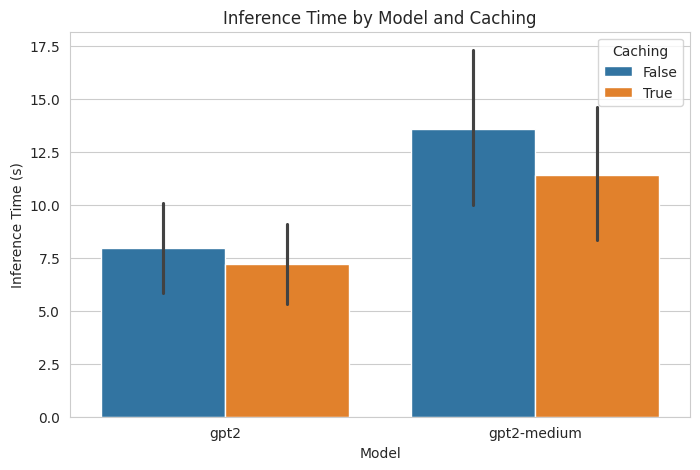

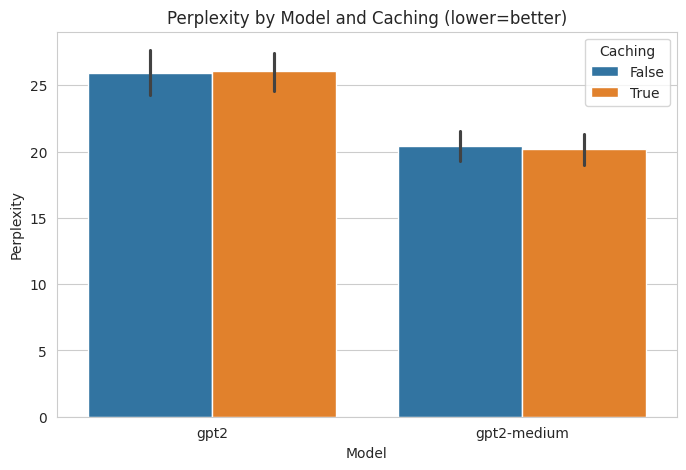

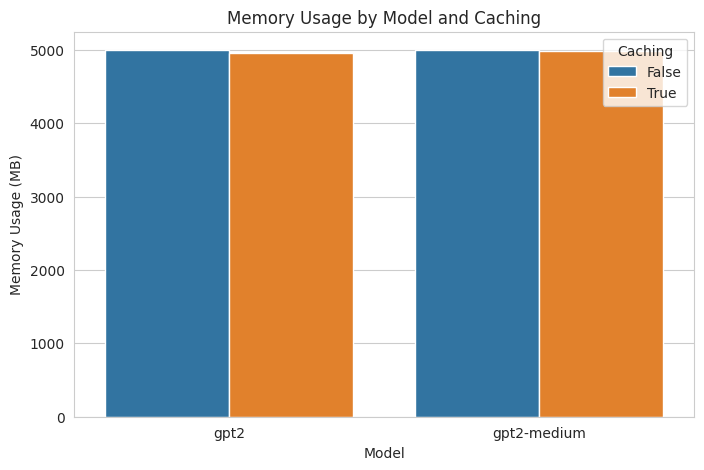

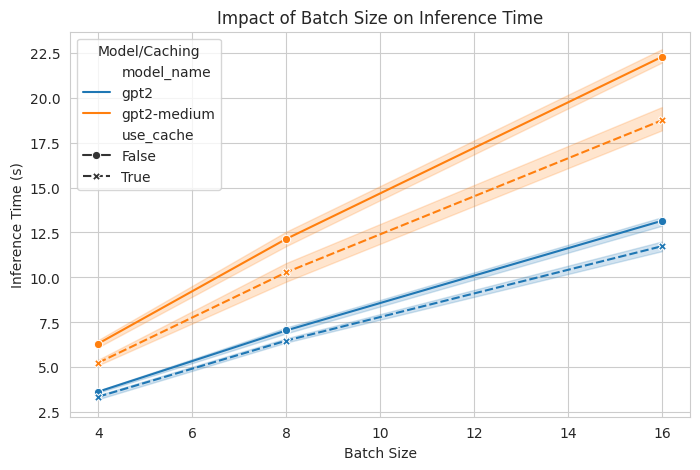

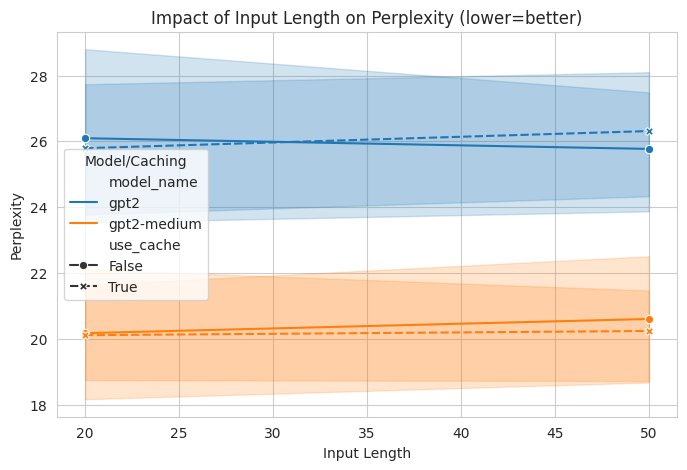

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='model_name', y='inference_time', hue='use_cache')
plt.title("Inference Time by Model and Caching")
plt.xlabel("Model")
plt.ylabel("Inference Time (s)")
plt.legend(title="Caching")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='model_name', y='perplexity', hue='use_cache')
plt.title("Perplexity by Model and Caching (lower=better)")
plt.xlabel("Model")
plt.ylabel("Perplexity")
plt.legend(title="Caching")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='model_name', y='memory_usage', hue='use_cache')
plt.title("Memory Usage by Model and Caching")
plt.xlabel("Model")
plt.ylabel("Memory Usage (MB)")
plt.legend(title="Caching")
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x='batch_size', y='inference_time',
             hue='model_name', style='use_cache', markers=True)
plt.title("Impact of Batch Size on Inference Time")
plt.xlabel("Batch Size")
plt.ylabel("Inference Time (s)")
plt.legend(title='Model/Caching')
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x='input_length', y='perplexity',
             hue='model_name', style='use_cache', markers=True)
plt.title("Impact of Input Length on Perplexity (lower=better)")
plt.xlabel("Input Length")
plt.ylabel("Perplexity")
plt.legend(title='Model/Caching')
plt.show()

                            OLS Regression Results                            
Dep. Variable:         inference_time   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     138.8
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           5.54e-25
Time:                        04:13:45   Log-Likelihood:                -82.748
No. Observations:                  48   AIC:                             177.5
Df Residuals:                      42   BIC:                             188.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
use_cache        1.4517      0.419      3.468   

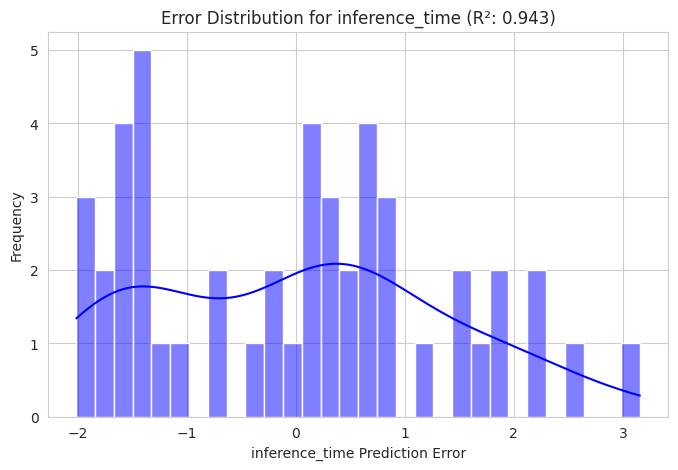

Model saved as 'inference_time_model.joblib'


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

def run_linear_regression(df, target_column, features):
    """
    Performs linear regression with categorical variables and plots the error distribution.
    """
    # Copying the DataFrame and transforming categorical variables
    df = df.copy()
    for col in ['model_name', 'use_cache']:  # Categorical columns
        if col in features:
            df[col] = pd.factorize(df[col])[0]  # Transforming to numeric format

    # Preparing the data
    X = df[features]
    X = sm.add_constant(X)  # Adding a constant
    y = df[target_column]

    # Linear regression
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Predictions and errors
    predictions = model.predict(X)
    errors = y - predictions

    # Visualizing the error distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(errors, bins=30, kde=True, color='blue')
    plt.title(f'Error Distribution for {target_column} (R²: {model.rsquared:.3f})')
    plt.xlabel(f'{target_column} Prediction Error')
    plt.ylabel('Frequency')
    plt.show()

    return model

# Example usage
features = ['use_cache', 'batch_size', 'input_length', 'temperature', 'top_k', 'top_p', 'model_name']
target_column = 'inference_time'
regression_model = run_linear_regression(results_df, target_column, features)

joblib.dump(regression_model, "inference_time_model.joblib")
print("Model saved as 'inference_time_model.joblib'")


Regression model loaded successfully.
Running simulation...



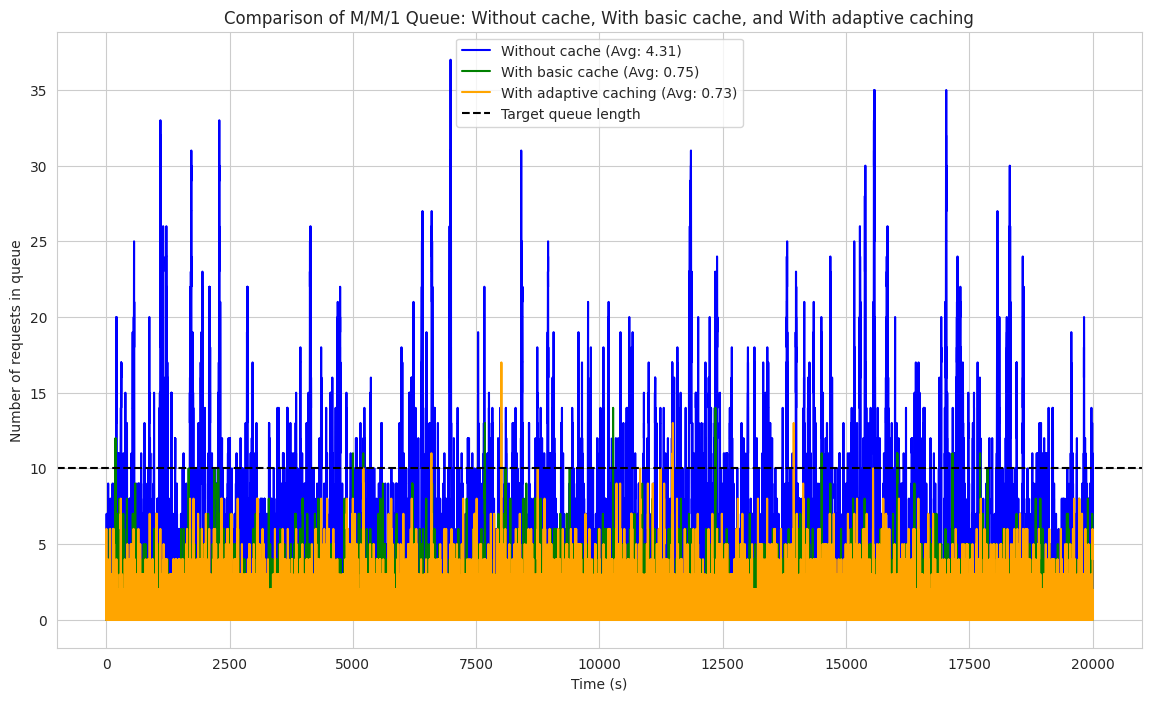

Without cache:
  Average wait time: 1.07
  Cache hits: 0
  Cache misses: 0
  Hit Rate: 0.00%

With basic cache:
  Average wait time: 0.27
  Cache hits: 32056
  Cache misses: 47717
  Hit Rate: 40.18%

With adaptive caching:
  Average wait time: 0.27
  Cache hits: 32377
  Cache misses: 47901
  Hit Rate: 40.33%



In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
from cachetools import TTLCache
from joblib import load
import pandas as pd
import numpy as np

# System parameters
lambda_rate = 4          # Arrival rate (λ)
mu_rate = 5              # Service rate (μ)
simulation_time = 20000  # Total simulation time
num_servers = 1          # Number of servers
target_queue_size = 10   # Target queue length
repeat_probability = 0.5 # Probability of repeat request

# Cache parameters
initial_cache_size = 50  # Initial cache size
initial_ttl = 30         # Initial TTL for cache elements

# Number of simulation runs
num_runs = 1
existing_requests = list(range(0, 10))  # Set of requests

# Loading the regression model
try:
    regression_model = load("inference_time_model.joblib")
    print("Regression model loaded successfully.")
except FileNotFoundError:
    print("Error: Model file not found.")
    regression_model = None

# Function to process request with cache
def process_request_with_cache(env, request_id, server, cache, results):
    arrival_time = env.now
    if random.random() < repeat_probability:
        request_id = random.choice(existing_requests)

    if request_id in cache:
        results["hits"] += 1
        yield env.timeout(0.1)  # Fast service from cache
    else:
        results["misses"] += 1
        with server.request() as req:
            yield req
            service_time = random.expovariate(mu_rate)
            yield env.timeout(service_time)
            cache[request_id] = env.now  # Add to cache

    wait_time = env.now - arrival_time
    results["wait_times"].append(wait_time)
    results["queue_length"].append(len(server.queue))
    results["time"].append(env.now)

# Function to process request without cache
def process_request_no_cache(env, request_id, server, results):
    arrival_time = env.now
    with server.request() as req:
        yield req
        service_time = random.expovariate(mu_rate)
        yield env.timeout(service_time)

    wait_time = env.now - arrival_time
    results["wait_times"].append(wait_time)
    results["queue_length"].append(len(server.queue))
    results["time"].append(env.now)

# Predictive controller
from collections import deque

def predictive_controller(env, cache, results):
    print(f"[DEBUG] Predictive Controller started")

    window_size = 5  # Moving average window size
    hits_window = deque(maxlen=window_size)
    misses_window = deque(maxlen=window_size)
    previous_hits = results["hits"]
    previous_misses = results["misses"]

    while True:
        if regression_model:
            # Creating features for the model
            hits_diff = results["hits"] - previous_hits
            misses_diff = results["misses"] - previous_misses
            hits_window.append(hits_diff)
            misses_window.append(misses_diff)
            previous_hits = results["hits"]
            previous_misses = results["misses"]

            avg_hits = sum(hits_window) / len(hits_window) if hits_window else 0
            avg_misses = sum(misses_window) / len(misses_window) if misses_window else 0

            # New feature set
            input_features = pd.DataFrame([{
                'use_cache': 1,
                'batch_size': random.randint(8, 16),
                'input_length': random.randint(20, 100),
                'temperature': random.uniform(0.7, 1.0),
                'top_k': random.randint(10, 50),
                'top_p': round(random.uniform(0.8, 0.95), 2),
                'model_name': 0,
                'cache_maxsize': cache.maxsize,
                'avg_hits': avg_hits,
                'avg_misses': avg_misses,
                'hit_miss_ratio': avg_hits / (avg_misses + 1e-5)  # Prevent division by 0
            }])

            # Model prediction
            predicted_time = regression_model.predict(input_features)[0]
            print(f"[DEBUG] Predicted time: {predicted_time:.2f}, Avg Hits: {avg_hits}, Avg Misses: {avg_misses}")

            # Adaptation logic
            if avg_misses > avg_hits:
                new_maxsize = min(cache.maxsize + 50, 200)  # Aggressively increase cache size
                new_ttl = min(cache.ttl + 10, 40)
            else:
                new_maxsize = max(cache.maxsize - 20, 50)  # Gradually decrease cache size
                new_ttl = max(cache.ttl - 5, 10)

            # Update cache
            if new_maxsize != cache.maxsize or new_ttl != cache.ttl:
                print(f"[DEBUG] Updating cache: size={new_maxsize}, ttl={new_ttl}")
                new_cache = TTLCache(maxsize=new_maxsize, ttl=new_ttl)
                for key, value in cache.items():
                    new_cache[key] = value
                cache.clear()
                cache.update(new_cache)

        yield env.timeout(5)  # Update interval

# Generate requests
def generate_requests(env, server, cache_enabled, adaptive, results):
    cache = TTLCache(maxsize=initial_cache_size, ttl=initial_ttl) if cache_enabled else None
    if adaptive and cache:
        env.process(predictive_controller(env, cache, results))

    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        if cache_enabled:
            env.process(process_request_with_cache(env, request_id, server, cache, results))
        else:
            env.process(process_request_no_cache(env, request_id, server, results))
        request_id += 1

# Run simulation
def run_simulation(cache_enabled=False, adaptive=False):
    results = {"time": [], "queue_length": [], "hits": 0, "misses": 0, "wait_times": []}
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)
    env.process(generate_requests(env, server, cache_enabled, adaptive, results))
    env.run(until=simulation_time)
    return results

# Plot results
def plot_results(all_results):
    plt.figure(figsize=(14, 8))
    colors = ['blue', 'green', 'orange']
    labels = ["Without cache", "With basic cache", "With adaptive caching"]

    for i, (label, result) in enumerate(all_results.items()):
        plt.plot(result['time'], result['queue_length'], label=f"{labels[i]} (Avg: {np.mean(result['queue_length']):.2f})", color=colors[i])

    plt.axhline(y=target_queue_size, color='k', linestyle='--', label="Target queue length")
    plt.title("Comparison of M/M/1 Queue: Without cache, With basic cache, and With adaptive caching")
    plt.xlabel("Time (s)")
    plt.ylabel("Number of requests in queue")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    print("Running simulation...\n")

    # Collect results
    results_no_cache = run_simulation(cache_enabled=False)
    results_basic_cache = run_simulation(cache_enabled=True)
    results_adaptive_cache = run_simulation(cache_enabled=True, adaptive=True)

    all_results = {
        "Without cache": results_no_cache,
        "With basic cache": results_basic_cache,
        "With adaptive caching": results_adaptive_cache
    }

    # Plot results
    plot_results(all_results)

    # Print statistics
    for label, result in all_results.items():
        total_requests = result["hits"] + result["misses"]
        hit_rate = result["hits"] / total_requests if total_requests > 0 else 0
        avg_wait = np.mean(result["wait_times"])

        print(f"{label}:")
        print(f"  Average wait time: {avg_wait:.2f}")
        print(f"  Cache hits: {result['hits']}")
        print(f"  Cache misses: {result['misses']}")
        print(f"  Hit Rate: {hit_rate:.2%}\n")

if __name__ == "__main__":
    main()


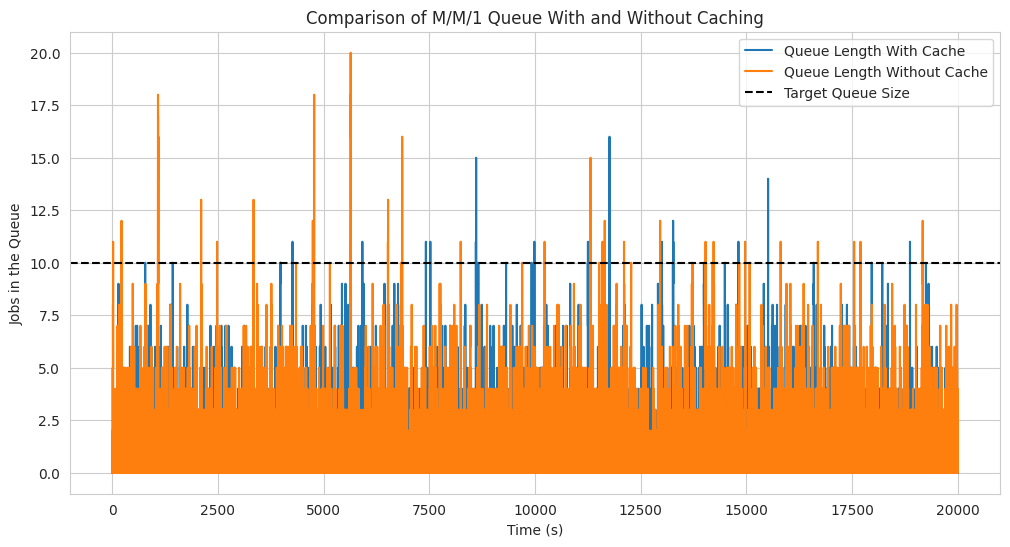

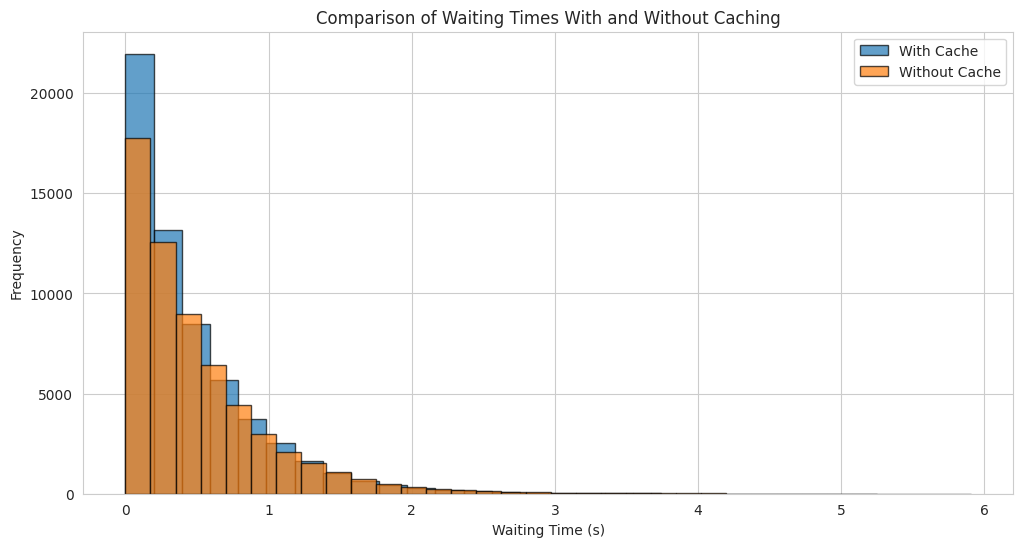

Average Waiting Time With Cache: 0.45 units of time
Average Waiting Time Without Cache: 0.50 units of time


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
from cachetools import TTLCache

# System parameters
lambda_rate = 3  # Arrival rate
mu_rate = 5      # Service rate
simulation_time = 20000  # Total simulation time
target_queue_size = 10  # Target queue length
repeat_probability = 0.3  # Probability of a repeat request

# Cache
cache = TTLCache(maxsize=50, ttl=10)

# Logging
time_data_with_cache = []
queue_data_with_cache = []
wait_times_with_cache = []

time_data_no_cache = []
queue_data_no_cache = []
wait_times_no_cache = []

# List for random repeat requests
existing_requests = list(range(0, 100))

# Service process with cache
def process_request_with_cache(env, request_id, server):
    arrival_time = env.now
    queue_data_with_cache.append(len(server.queue))
    time_data_with_cache.append(env.now)

    # Check for repeat request
    if random.random() < repeat_probability:
        request_id = random.choice(existing_requests)

    if request_id in cache:
        yield env.timeout(0.1)  # Fast service from cache
    else:
        with server.request() as request:
            yield request
            service_time = random.expovariate(mu_rate)
            yield env.timeout(service_time)
            cache[request_id] = env.now  # Add result to cache

    wait_times_with_cache.append(env.now - arrival_time)

# Service process without cache
def process_request_no_cache(env, request_id, server):
    arrival_time = env.now
    queue_data_no_cache.append(len(server.queue))
    time_data_no_cache.append(env.now)

    with server.request() as request:
        yield request
        service_time = random.expovariate(mu_rate)
        yield env.timeout(service_time)

    wait_times_no_cache.append(env.now - arrival_time)

# Request generation
def generate_requests_with_cache(env, server):
    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(process_request_with_cache(env, request_id, server))
        request_id += 1

def generate_requests_no_cache(env, server):
    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(process_request_no_cache(env, request_id, server))
        request_id += 1

# Run simulation
def run_simulation():
    # With cache
    env_with_cache = simpy.Environment()
    server_with_cache = simpy.Resource(env_with_cache, capacity=1)
    env_with_cache.process(generate_requests_with_cache(env_with_cache, server_with_cache))
    env_with_cache.run(until=simulation_time)

    # Without cache
    env_no_cache = simpy.Environment()
    server_no_cache = simpy.Resource(env_no_cache, capacity=1)
    env_no_cache.process(generate_requests_no_cache(env_no_cache, server_no_cache))
    env_no_cache.run(until=simulation_time)

    # Plot graphs
    plt.figure(figsize=(12, 6))
    plt.plot(time_data_with_cache, queue_data_with_cache, label="Queue Length With Cache")
    plt.plot(time_data_no_cache, queue_data_no_cache, label="Queue Length Without Cache")
    plt.axhline(target_queue_size, color='k', linestyle='--', label="Target Queue Size")
    plt.xlabel("Time (s)")
    plt.ylabel("Jobs in the Queue")
    plt.title("Comparison of M/M/1 Queue With and Without Caching")
    plt.legend()
    plt.show()

    # Histogram of waiting times
    plt.figure(figsize=(12, 6))
    plt.hist(wait_times_with_cache, bins=30, alpha=0.7, label="With Cache", edgecolor='black')
    plt.hist(wait_times_no_cache, bins=30, alpha=0.7, label="Without Cache", edgecolor='black')
    plt.title('Comparison of Waiting Times With and Without Caching')
    plt.xlabel('Waiting Time (s)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Output statistics
    avg_wait_with_cache = sum(wait_times_with_cache) / len(wait_times_with_cache) if wait_times_with_cache else 0
    avg_wait_no_cache = sum(wait_times_no_cache) / len(wait_times_no_cache) if wait_times_no_cache else 0

    print(f"Average Waiting Time With Cache: {avg_wait_with_cache:.2f} units of time")
    print(f"Average Waiting Time Without Cache: {avg_wait_no_cache:.2f} units of time")

# Run
if __name__ == "__main__":
    run_simulation()


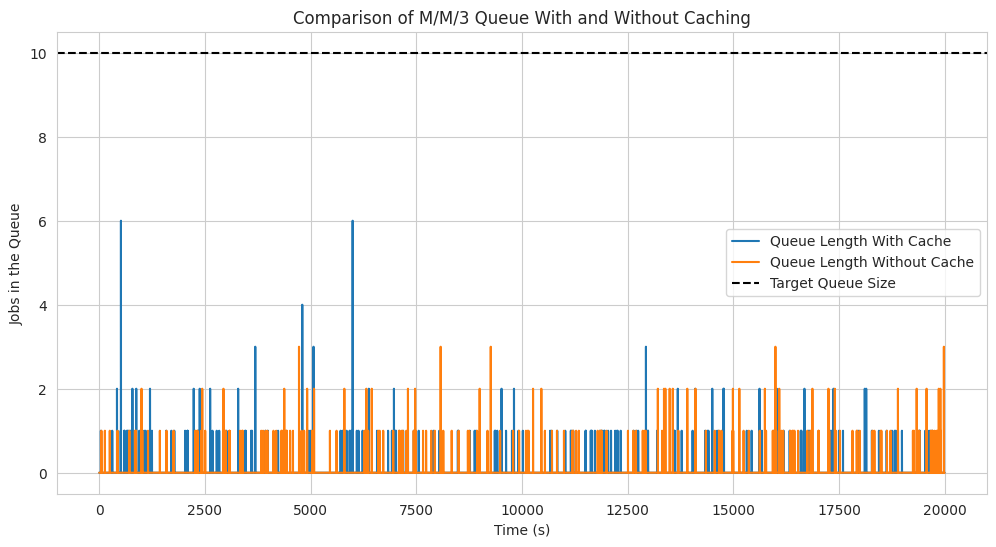

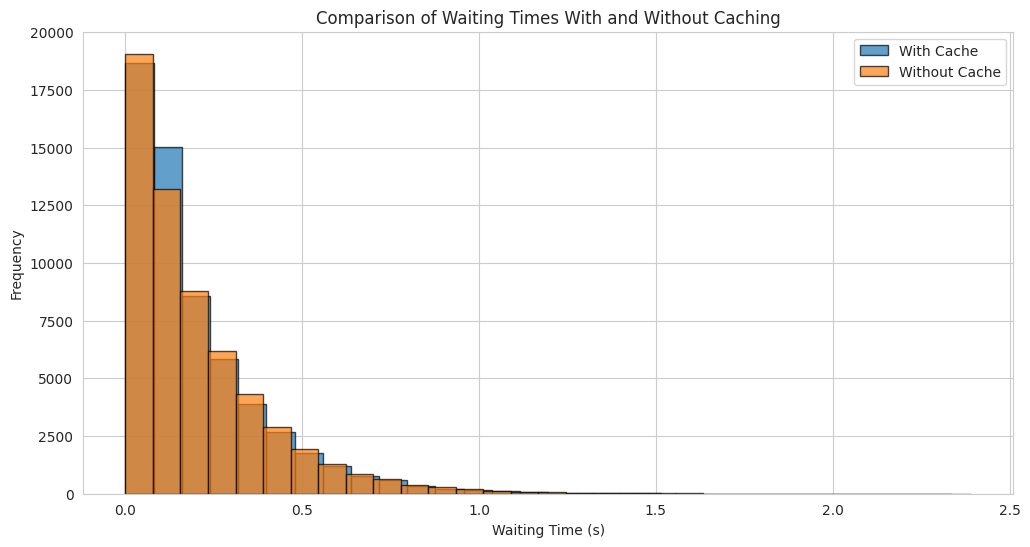

Average Waiting Time With Cache: 0.1974 units of time
Average Waiting Time Without Cache: 0.2032 units of time


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
from cachetools import TTLCache

# System parameters
lambda_rate = 3  # Arrival rate
mu_rate = 5      # Service rate
simulation_time = 20000  # Total simulation time
target_queue_size = 10  # Target queue length
repeat_probability = 0.3  # Probability of a repeat request
num_servers = 3  # Number of servers

# Cache
cache = TTLCache(maxsize=50, ttl=10)

# Logging
time_data_with_cache = []
queue_data_with_cache = []
wait_times_with_cache = []

time_data_no_cache = []
queue_data_no_cache = []
wait_times_no_cache = []

# List for random repeat requests
existing_requests = list(range(0, 100))

# Service process with cache
def process_request_with_cache(env, request_id, server):
    arrival_time = env.now
    queue_data_with_cache.append(len(server.queue))
    time_data_with_cache.append(env.now)

    # Check for repeat request
    if random.random() < repeat_probability:
        request_id = random.choice(existing_requests)

    if request_id in cache:
        yield env.timeout(0.1)  # Fast service from cache
    else:
        with server.request() as request:
            yield request
            service_time = random.expovariate(mu_rate)
            yield env.timeout(service_time)
            cache[request_id] = env.now  # Add result to cache

    wait_times_with_cache.append(env.now - arrival_time)

# Service process without cache
def process_request_no_cache(env, request_id, server):
    arrival_time = env.now
    queue_data_no_cache.append(len(server.queue))
    time_data_no_cache.append(env.now)

    with server.request() as request:
        yield request
        service_time = random.expovariate(mu_rate)
        yield env.timeout(service_time)

    wait_times_no_cache.append(env.now - arrival_time)

# Request generation
def generate_requests_with_cache(env, server):
    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(process_request_with_cache(env, request_id, server))
        request_id += 1

def generate_requests_no_cache(env, server):
    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        env.process(process_request_no_cache(env, request_id, server))
        request_id += 1

# Run simulation
def run_simulation():
    # With cache
    env_with_cache = simpy.Environment()
    server_with_cache = simpy.Resource(env_with_cache, capacity=num_servers)
    env_with_cache.process(generate_requests_with_cache(env_with_cache, server_with_cache))
    env_with_cache.run(until=simulation_time)

    # Without cache
    env_no_cache = simpy.Environment()
    server_no_cache = simpy.Resource(env_no_cache, capacity=num_servers)
    env_no_cache.process(generate_requests_no_cache(env_no_cache, server_no_cache))
    env_no_cache.run(until=simulation_time)

    # Plot graphs
    plt.figure(figsize=(12, 6))
    plt.plot(time_data_with_cache, queue_data_with_cache, label="Queue Length With Cache")
    plt.plot(time_data_no_cache, queue_data_no_cache, label="Queue Length Without Cache")
    plt.axhline(target_queue_size, color='k', linestyle='--', label="Target Queue Size")
    plt.xlabel("Time (s)")
    plt.ylabel("Jobs in the Queue")
    plt.title("Comparison of M/M/3 Queue With and Without Caching")
    plt.legend()
    plt.show()

    # Histogram of waiting times
    plt.figure(figsize=(12, 6))
    plt.hist(wait_times_with_cache, bins=30, alpha=0.7, label="With Cache", edgecolor='black')
    plt.hist(wait_times_no_cache, bins=30, alpha=0.7, label="Without Cache", edgecolor='black')
    plt.title('Comparison of Waiting Times With and Without Caching')
    plt.xlabel('Waiting Time (s)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Output statistics
    avg_wait_with_cache = sum(wait_times_with_cache) / len(wait_times_with_cache) if wait_times_with_cache else 0
    avg_wait_no_cache = sum(wait_times_no_cache) / len(wait_times_no_cache) if wait_times_no_cache else 0

    print(f"Average Waiting Time With Cache: {avg_wait_with_cache:.4f} units of time")
    print(f"Average Waiting Time Without Cache: {avg_wait_no_cache:.4f} units of time")

# Run
if __name__ == "__main__":
    run_simulation()


--- Running Simulation 1 ---
--- Running Simulation 2 ---
--- Running Simulation 3 ---
--- Running Simulation 4 ---
--- Running Simulation 5 ---


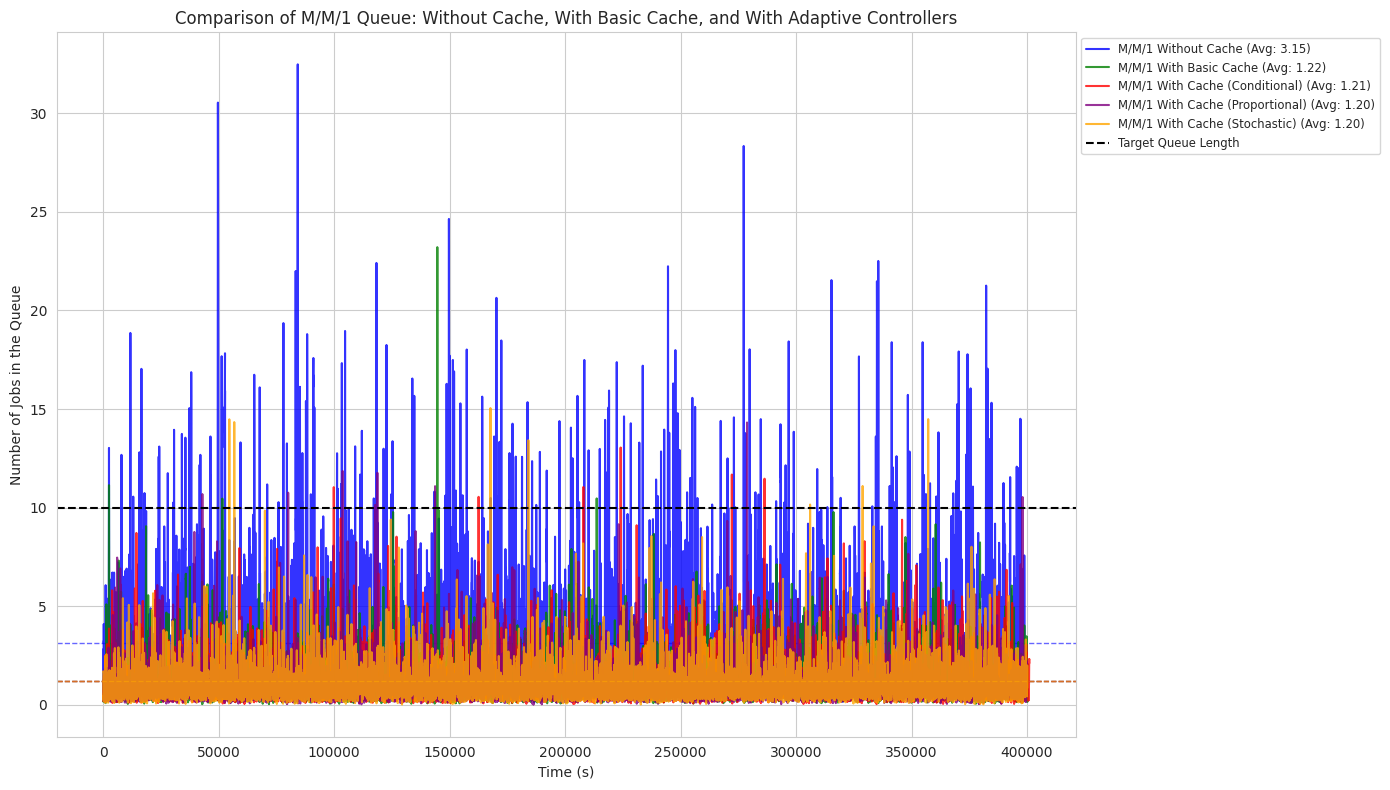

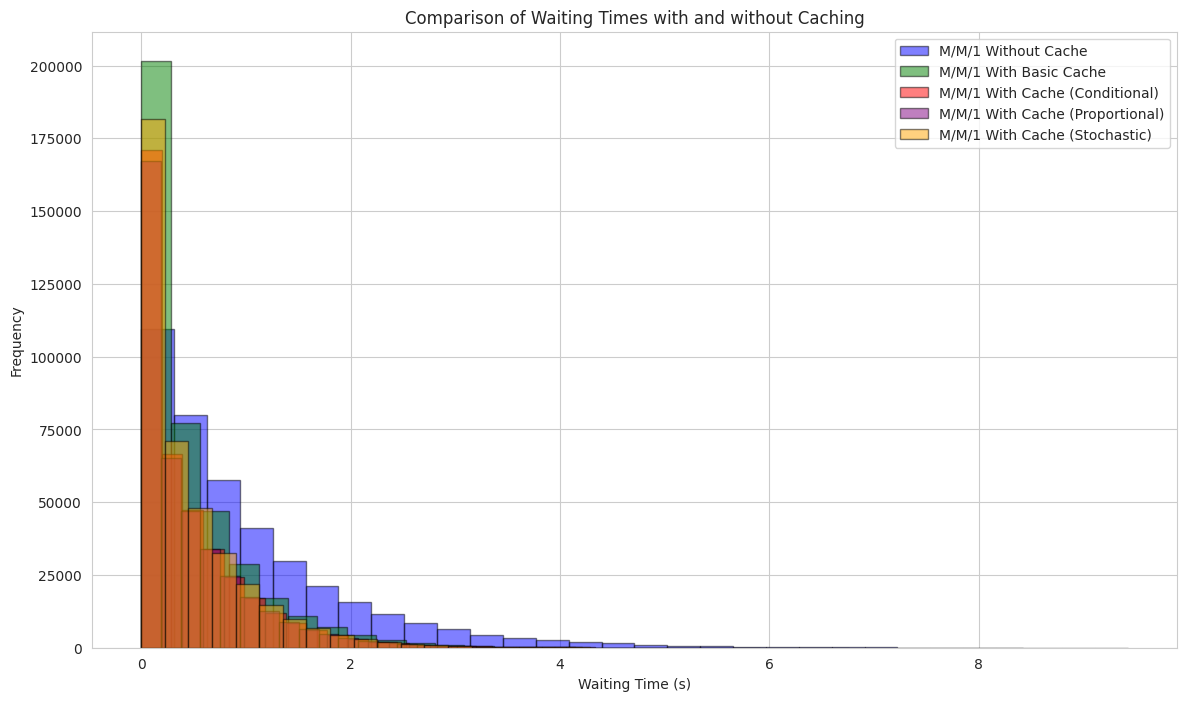

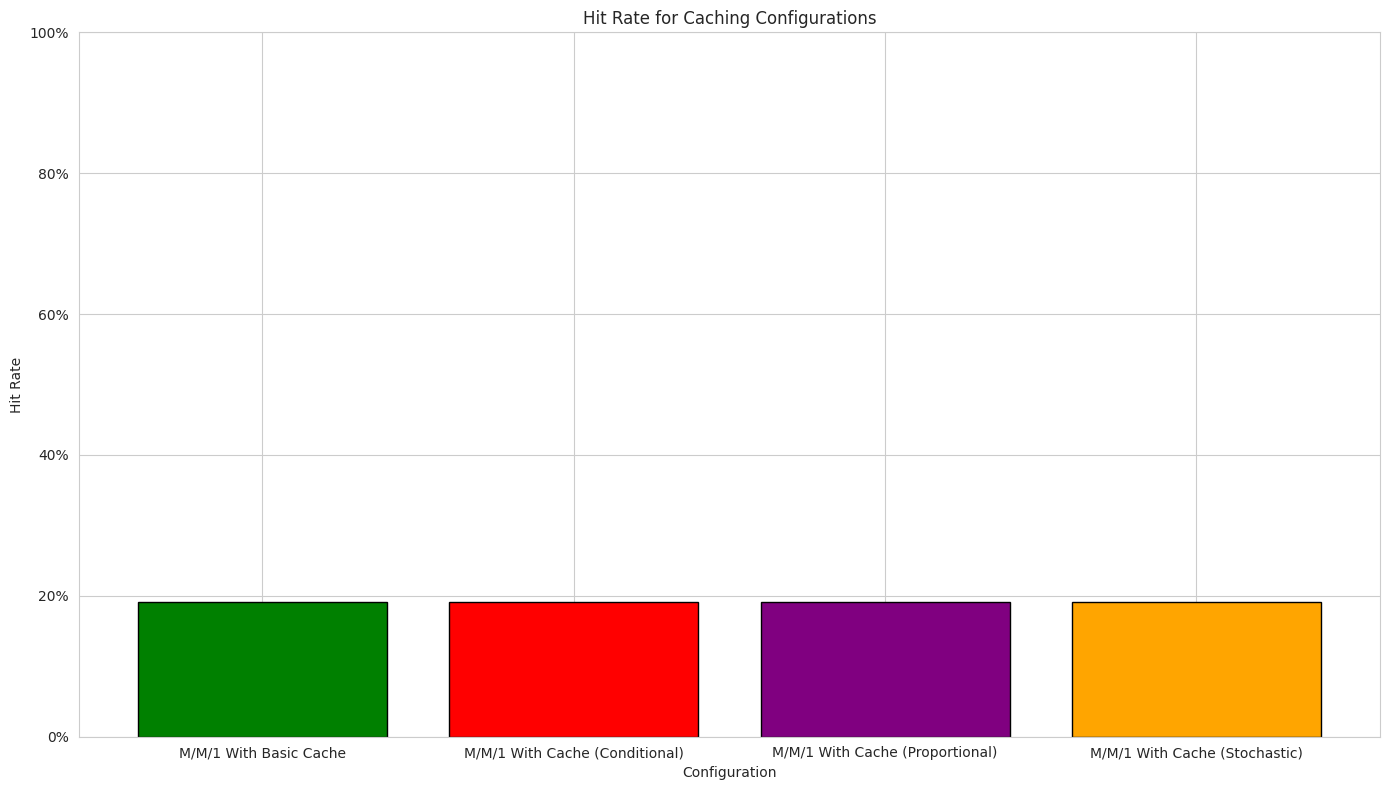


--- Averaged Simulation Results ---
M/M/1 Without Cache:
  Average Waiting Time: 0.99 time units
  Average Queue Length: 3.15 jobs

M/M/1 With Basic Cache:
  Average Waiting Time: 0.49 time units
  Average Queue Length: 1.22 jobs
  Cache Hits: 76496
  Cache Misses: 323845
  Hit Rate: 19.11%

M/M/1 With Cache (Conditional):
  Average Waiting Time: 0.48 time units
  Average Queue Length: 1.21 jobs
  Cache Hits: 76435
  Cache Misses: 324618
  Hit Rate: 19.06%

M/M/1 With Cache (Proportional):
  Average Waiting Time: 0.48 time units
  Average Queue Length: 1.20 jobs
  Cache Hits: 76412
  Cache Misses: 323353
  Hit Rate: 19.11%

M/M/1 With Cache (Stochastic):
  Average Waiting Time: 0.48 time units
  Average Queue Length: 1.20 jobs
  Cache Hits: 76425
  Cache Misses: 323780
  Hit Rate: 19.10%



In [ ]:
import simpy
import random
import matplotlib.pyplot as plt
from cachetools import TTLCache
import numpy as np

# System parameters
lambda_rate = 4          # Arrival rate (increased for higher load)
mu_rate = 5              # Service rate
simulation_time = 20000  # Total simulation time
num_servers = 1          # Number of servers
target_queue_size = 10   # Target queue length
repeat_probability = 0.5 # Increased probability of repeat requests

# Cache parameters
initial_cache_size = 100  # Increased initial cache size
initial_ttl = 20          # Increased initial TTL
max_cache_size = 200      # Increased maximum cache size
min_cache_size = 50       # Increased minimum cache size
max_ttl = 30              # Increased maximum TTL
min_ttl = 10              # Increased minimum TTL
adjustment_step = 2       # Decreased adjustment step for smoother changes

# Number of simulation runs
num_runs = 5

# List for random repeat requests
existing_requests = list(range(0, 100))

# Controllers
def conditional_controller(queue_length, error):
    if error > 2:
        return adjustment_step, +1  # Increase TTL when the queue length increases
    elif error < -2:
        return -adjustment_step, -1  # Decrease TTL when the queue length decreases
    return 0, 0

def proportional_controller(queue_length, error):
    change = int(adjustment_step * (error / target_queue_size))
    ttl_change = int(error / target_queue_size)  # TTL change proportional to the error
    return change, ttl_change

def stochastic_controller(queue_length, error):
    if random.random() < abs(error) / target_queue_size:
        change = adjustment_step if error > 0 else -adjustment_step
        ttl_change = +1 if error > 0 else -1  # Adjust TTL direction
        return change, ttl_change
    return 0, 0

controllers = {
    "Conditional": conditional_controller,
    "Proportional": proportional_controller,
    "Stochastic": stochastic_controller
}

# Adaptive cache controller
def adaptive_cache_controller(env, server, controller_name, cache, run_id, results, label):
    controller = controllers[controller_name]
    while True:
        queue_length = len(server.queue)
        error = queue_length - target_queue_size
        size_change, ttl_change = controller(queue_length, error)

        # Adjust cache size
        new_size = max(min(cache.maxsize + size_change, max_cache_size), min_cache_size)
        new_ttl = max(min(cache.ttl + ttl_change, max_ttl), min_ttl)

        # If parameters change, recreate the cache while retaining existing items
        if new_size != cache.maxsize or new_ttl != cache.ttl:
            new_cache = TTLCache(maxsize=new_size, ttl=new_ttl)
            # Transfer existing items
            for key, value in cache.items():
                new_cache[key] = value
            cache.clear()
            for key in new_cache:
                cache[key] = new_cache[key]

        yield env.timeout(5)  # Adjustment period

# Process request with cache
def process_request_with_cache(env, request_id, server, cache, cache_enabled, label, run_id, results):
    arrival_time = env.now

    # Log queue length
    queue_length = len(server.queue)
    results["queue_data"].append(queue_length)

    # Check for repeat request
    if cache_enabled and random.random() < repeat_probability:
        request_id = random.choice(existing_requests)

    if cache_enabled and request_id in cache:
        # Cache hit
        results["hits"] += 1
        yield env.timeout(0.1)  # Fast service from cache
    else:
        if cache_enabled:
            results["misses"] += 1
        with server.request() as request:
            yield request
            service_time = random.expovariate(mu_rate)
            yield env.timeout(service_time)
            if cache_enabled:
                cache[request_id] = env.now  # Add result to cache

    # Log waiting time
    wait_time = env.now - arrival_time
    results["wait_times"].append(wait_time)

# Process request without cache
def process_request_no_cache(env, request_id, server, label, run_id, results):
    arrival_time = env.now

    # Log queue length
    queue_length = len(server.queue)
    results["queue_data"].append(queue_length)

    with server.request() as request:
        yield request
        service_time = random.expovariate(mu_rate)
        yield env.timeout(service_time)

    # Log waiting time
    wait_time = env.now - arrival_time
    results["wait_times"].append(wait_time)

# Request generation
def generate_requests(env, server, cache, cache_enabled, label, run_id, controller_name, results):
    if controller_name and cache_enabled:
        # Run adaptive cache controller
        env.process(adaptive_cache_controller(env, server, controller_name, cache, run_id, results, label))
    request_id = 0
    while True:
        yield env.timeout(random.expovariate(lambda_rate))
        if cache_enabled:
            env.process(process_request_with_cache(env, request_id, server, cache, cache_enabled, label, run_id, results))
        else:
            env.process(process_request_no_cache(env, request_id, server, label, run_id, results))
        request_id += 1

# Run a single simulation
def run_single_simulation(run_id, labels, controllers_list):
    local_results = {label: {"queue_data": [], "wait_times": [], "hits": 0, "misses": 0} for label in labels}

    for label, controller_name in controllers_list.items():
        env = simpy.Environment()
        server = simpy.Resource(env, capacity=num_servers)
        cache = None

        # Изменённое условие проверки
        if "With " in label and "Cache" in label:
            cache = TTLCache(maxsize=initial_cache_size, ttl=initial_ttl)
            env.process(generate_requests(env, server, cache, True, label, run_id, controller_name, local_results[label]))
        else:
            # Исправлено: используем local_results вместо results
            env.process(generate_requests(env, server, cache, False, label, run_id, controller_name, local_results[label]))

        env.run(until=simulation_time)

    return local_results

# Main function for running all simulations
def main():
    labels = [
        "M/M/1 Without Cache",
        "M/M/1 With Basic Cache",
        "M/M/1 With Cache (Conditional)",
        "M/M/1 With Cache (Proportional)",
        "M/M/1 With Cache (Stochastic)"
    ]

    controllers_list = {
        "M/M/1 Without Cache": None,
        "M/M/1 With Basic Cache": None,
        "M/M/1 With Cache (Conditional)": "Conditional",
        "M/M/1 With Cache (Proportional)": "Proportional",
        "M/M/1 With Cache (Stochastic)": "Stochastic"
    }

    # Initialize results
    results = {label: {"queue_data": [], "wait_times": [], "hits": 0, "misses": 0} for label in labels}

    # Run simulations
    for run_id in range(1, num_runs + 1):
        print(f"--- Running Simulation {run_id} ---")
        run_results = run_single_simulation(run_id, labels, controllers_list)
        for label in labels:
            results[label]["queue_data"].extend(run_results[label]["queue_data"])
            results[label]["wait_times"].extend(run_results[label]["wait_times"])
            results[label]["hits"] += run_results[label]["hits"]
            results[label]["misses"] += run_results[label]["misses"]

    # Calculate averages across all runs
    averaged_results = {}
    for label in labels:
        averaged_results[label] = {
            "avg_wait": np.mean(results[label]["wait_times"]) if results[label]["wait_times"] else 0,
            "avg_queue": np.mean(results[label]["queue_data"]) if results[label]["queue_data"] else 0,
            "hits": results[label]["hits"],
            "misses": results[label]["misses"],
            "hit_rate": results[label]["hits"] / (results[label]["hits"] + results[label]["misses"]) if (results[label]["hits"] + results[label]["misses"]) > 0 else 0
        }

    # Plot queue length
    plt.figure(figsize=(14, 8))
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for idx, label in enumerate(labels):
        queue_data = results[label]["queue_data"]
        if not queue_data:
            continue
        # Smooth the data for plotting
        window = 100
        if len(queue_data) >= window:
            smoothed_queue = np.convolve(queue_data, np.ones(window)/window, mode='valid')
            time_data = np.arange(len(smoothed_queue))
        else:
            smoothed_queue = queue_data
            time_data = np.arange(len(smoothed_queue))
        average_queue_size = averaged_results[label]["avg_queue"]
        plt.plot(time_data, smoothed_queue, label=f"{label} (Avg: {average_queue_size:.2f})", color=colors[idx], linewidth=1.5, alpha=0.8)
        plt.axhline(average_queue_size, color=colors[idx], linestyle='--', linewidth=1, alpha=0.6)

    plt.axhline(target_queue_size, color='k', linestyle='--', linewidth=1.5, label="Target Queue Length")
    plt.title("Comparison of M/M/1 Queue: Without Cache, With Basic Cache, and With Adaptive Controllers")
    plt.xlabel("Time (s)")
    plt.ylabel("Number of Jobs in the Queue")
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Plot waiting time histogram
    plt.figure(figsize=(14, 8))
    bins = 30
    for idx, label in enumerate(labels):
        wait_times = results[label]["wait_times"]
        if not wait_times:
            continue
        plt.hist(wait_times, bins=bins, alpha=0.5, label=label, color=colors[idx], edgecolor='black')

    plt.title('Comparison of Waiting Times with and without Caching')
    plt.xlabel('Waiting Time (s)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Plot hit rate histogram
    plt.figure(figsize=(14, 8))
    hit_rates = [averaged_results[label]["hit_rate"] for label in labels if "With " in label and "Cache" in label]
    cache_labels = [label for label in labels if "With " in label and "Cache" in label]
    plt.bar(cache_labels, hit_rates, color=['green', 'red', 'purple', 'orange'], edgecolor='black')
    plt.title('Hit Rate for Caching Configurations')
    plt.xlabel('Configuration')
    plt.ylabel('Hit Rate')
    plt.ylim(0, 1)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n--- Averaged Simulation Results ---")
    for label in labels:
        avg_wait = averaged_results[label]["avg_wait"]
        avg_queue = averaged_results[label]["avg_queue"]
        hits = averaged_results[label]["hits"]
        misses = averaged_results[label]["misses"]
        hit_rate = averaged_results[label]["hit_rate"]
        print(f"{label}:")
        print(f"  Average Waiting Time: {avg_wait:.2f} time units")
        print(f"  Average Queue Length: {avg_queue:.2f} jobs")
        if "With " in label and "Cache" in label:
            print(f"  Cache Hits: {hits}")
            print(f"  Cache Misses: {misses}")
            print(f"  Hit Rate: {hit_rate:.2%}")
        print()

if __name__ == "__main__":
    main()
